In [20]:
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [21]:
metadata = joblib.load("metadata.pkl")

image_paths   = metadata["image_paths"]
labels        = metadata["labels"]
label_to_breed = metadata["label_to_breed"]
num_classes   = metadata["num_classes"]
IMG_SIZE      = metadata["img_size"]
BATCH_SIZE    = metadata["batch_size"]

print("Classes:", num_classes)


Classes: 37


In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)


In [23]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .shuffle(1000)
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [26]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels[:5])
    print([label_to_breed[int(l)] for l in labels[:5]])


(32, 224, 224, 3)
tf.Tensor([18 20 30 21  1], shape=(5,), dtype=int32)
['english_cocker_spaniel', 'german_shorthaired', 'saint_bernard', 'great_pyrenees', 'Bengal']


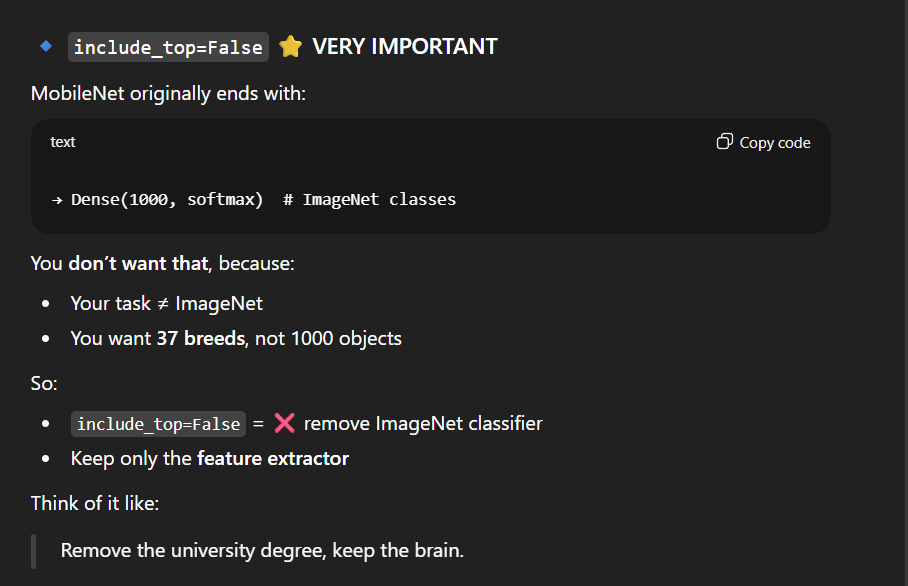

In [27]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # 🔒 freeze pretrained weights


In [28]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [30]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
185/185 [==============================] - 16s 69ms/step - loss: 1.1504 - accuracy: 0.6717 - val_loss: 0.3833 - val_accuracy: 0.8802
Epoch 2/10
185/185 [==============================] - 11s 60ms/step - loss: 0.4827 - accuracy: 0.8435 - val_loss: 0.3263 - val_accuracy: 0.8965
Epoch 3/10
185/185 [==============================] - 11s 59ms/step - loss: 0.3579 - accuracy: 0.8865 - val_loss: 0.3159 - val_accuracy: 0.8992
Epoch 4/10
185/185 [==============================] - 11s 59ms/step - loss: 0.2907 - accuracy: 0.9004 - val_loss: 0.3000 - val_accuracy: 0.9032
Epoch 5/10
185/185 [==============================] - 11s 58ms/step - loss: 0.2527 - accuracy: 0.9122 - val_loss: 0.3170 - val_accuracy: 0.8951
Epoch 6/10
185/185 [==============================] - 11s 59ms/step - loss: 0.2072 - accuracy: 0.9322 - val_loss: 0.3187 - val_accuracy: 0.8985
Epoch 7/10
185/185 [==============================] - 11s 60ms/step - loss: 0.1832 - accuracy: 0.9340 - val_loss: 0.3157 - val_accuracy:

In [31]:
model.save("breed_classifier_mobilenet.h5")
print("Model saved successfully")


Model saved successfully


In [32]:
model = tf.keras.models.load_model("breed_classifier_mobilenet.h5")
print("Model loaded")


Model loaded


In [33]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


47/47 [==============================] - 4s 47ms/step - loss: 0.3212 - accuracy: 0.9005
Validation Accuracy: 0.9005


In [34]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


47/47 [==============================] - 2s 47ms/step - loss: 0.3212 - accuracy: 0.9005
Validation Accuracy: 0.9005


In [35]:
def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img, verbose=0)[0]
    class_id = np.argmax(preds)
    confidence = preds[class_id]

    return label_to_breed[class_id], confidence


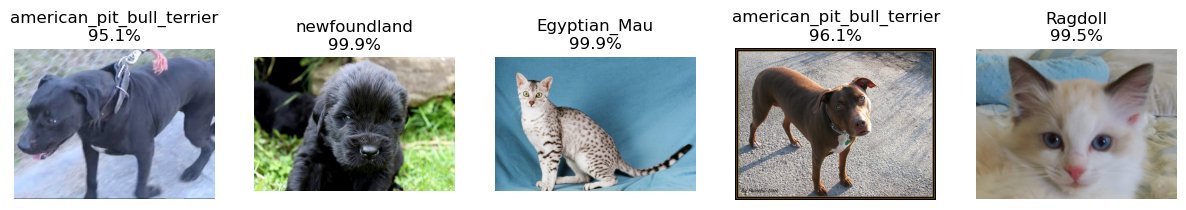

In [36]:
import random
import matplotlib.pyplot as plt
sample_paths = random.sample(list(X_val), 5)

plt.figure(figsize=(15,5))

for i, img_path in enumerate(sample_paths):
    breed, conf = predict_image(img_path)

    img = plt.imread(img_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"{breed}\n{conf*100:.1f}%")
    plt.axis("off")

plt.show()
